# Stock Prediction of Reliance Power Penny Stock using LSTM

## Loading Dependencies

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, LSTM
import math
from sklearn.metrics import mean_squared_error

## Importing Dataset

In [7]:
RPOWER_gsheet = "1pj9N5iVRFPyTmWuvNfgwVUJAiaqr-XPZXSPzotSobQA"
RPOWER_sheet_name = "RPOWER"
RPOWER_URL = "https://docs.google.com/spreadsheets/d/{}/gviz/tq?tqx=out:csv&sheet={}".format(RPOWER_gsheet, RPOWER_sheet_name)

RPOWER = pd.read_csv(RPOWER_URL)
RPOWER.to_csv("RPOWER.csv", sep=",", index=False, encoding="utf-8")
RPOWER.sample(11)

,Date,Open,High,Low,Close,Volume,Unnamed: 6
245,"Oct 22, 2021",16.10,16.35,15.15,15.30,"10,470,209",NaN
72,"Feb 9, 2021",3.70,3.75,3.45,3.50,"15,203,306",NaN
425,"Jul 13, 2022",11.60,11.70,11.40,11.50,"4,121,767",NaN
377,"May 6, 2022",13.25,13.25,12.95,13.10,"8,646,080",NaN
667,"Jul 7, 2023",15.30,15.65,14.90,15.25,"145,694,306",NaN
154,"Jun 11, 2021",12.50,12.50,11.40,12.50,"81,559,807",NaN
99,"Mar 19, 2021",4.35,4.45,4.35,4.35,"51,955,075",NaN
250,"Oct 29, 2021",14.10,14.60,14.10,14.10,"29,306,333",NaN
119,"Apr 22, 2021",4.55,4.70,4.45,4.50,"21,267,712",NaN
541,"Jan 2, 2023",14.45,14.85,14.40,14.70,"7,616,454",NaN


## EDA

We will be utilizing the High price of a stock for the data analysis and modeling. Thus, we will drop other columns and retain only the "High" column.

In [8]:
RPOWER1 = RPOWER.reset_index()["High"]

RPOWER1

0       3.75
1       3.40
2       3.10
3       3.60
4       3.80
       ...  
736    18.80
737    18.80
738    18.85
739    19.00
740    18.65
Name: High, Length: 741, dtype: float64

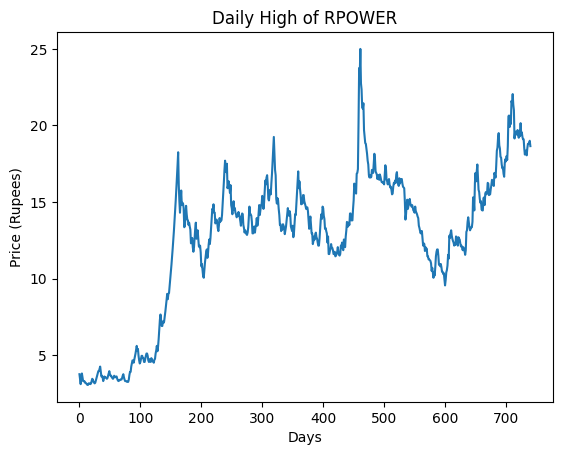

In [46]:
plt.plot(RPOWER1)
plt.title("Daily High of RPOWER")
plt.xlabel("Days")
plt.ylabel("Price (Rupees)")

plt.savefig("RPOWER.jpg")

## Preprocessing Data

### Transforming Data

LSTM is sensitive to the scale of data. Thus, we should always scale the data by transforming data to the range of [0,1] in order to stabilize the data.

In [10]:
 scaler = MinMaxScaler(feature_range=(0,1))

In [11]:
RPOWER1_fit = scaler.fit_transform(np.array(RPOWER1).reshape(-1,1))

RPOWER1_fit[:9]

array([[0.03189066],
       [0.01594533],
       [0.0022779 ],
       [0.02505695],
       [0.03416856],
       [0.02277904],
       [0.01138952],
       [0.01138952],
       [0.01138952]])

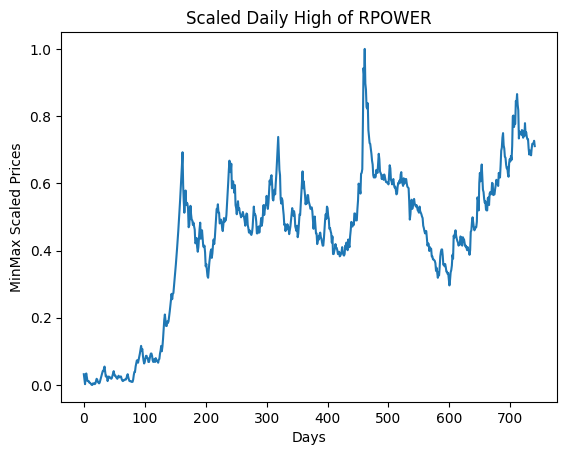

In [47]:
plt.plot(RPOWER1_fit)
plt.title("Scaled Daily High of RPOWER")
plt.xlabel("Days")
plt.ylabel("MinMax Scaled Prices")

plt.savefig("Scaled_RPOWER.jpg")

## Creating Dataset

### Train-Test Split 

After pre-processing the data, now we split each time series into test and train splits for testing and training the model

In [14]:
train_size = int(len(RPOWER1_fit)*0.65)
test_size = len(RPOWER1_fit) - train_size
train_data, test_data = RPOWER1_fit[:train_size,:], RPOWER1_fit[train_size:len(RPOWER1_fit),:1]

In [19]:
def split(arr):
    l = len(arr)
    train_size = int(len(arr)*0.6)
    
    train, test = arr[:train_size], arr[train_size: l]
    
    return train, test

def index(arr, len_train):
    df = pd.DataFrame(arr, [i for i in range(len_train+1, len_train+1+len(arr))])
    return df

def plot(arr, df):
    plt.plot(arr, color = "#e978d9")
    plt.plot(df, color = "#32a275")
    plt.title("Train-Test Split for RPOWER")
    plt.xlabel("Days")
    plt.ylabel("Price (Rupees)")

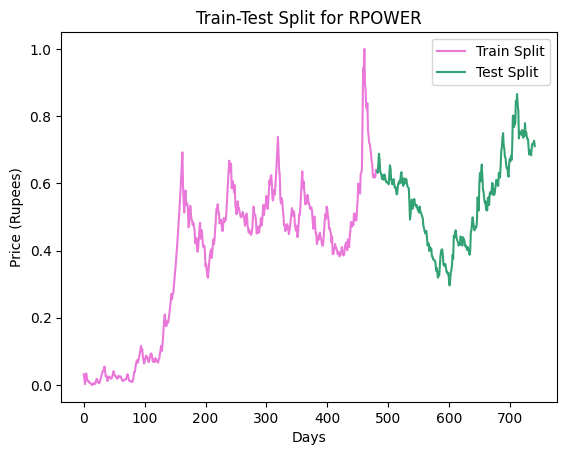

In [48]:
test_data_plt = index(test_data, len(train_data))

plot(train_data, test_data_plt)
plt.legend(["Train Split", "Test Split"])

plt.savefig("TrainTestSplit.jpg")

### Creating Dataset

In [23]:
def createDataset(dataset, timestep=100):
    X, Y = [],[]
    for i in range(len(dataset)-timestep-1):
        e = dataset[i:i+timestep,0]
        X.append(e)
        Y.append(dataset[i+timestep, 0])
        
    return np.array(X), np.array(Y)

def reshape(arr):
    return arr.reshape(arr.shape[0], arr.shape[1], 1)

In [25]:
X_train, Y_train = createDataset(train_data)
X_test, Y_test = createDataset(test_data)



In [26]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

## Designing the Model

In [27]:
model = Sequential()
model.add(LSTM(50, return_sequences = True, input_shape=(100,1)))
model.add(LSTM(50, return_sequences = True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss = "mean_squared_error", optimizer="adam")

In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50851 (198.64 KB)
Trainable params: 50851 (198.64 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Training Neural Network

In [29]:
model.fit(X_train, Y_train, validation_data = (X_test, Y_test), epochs = 100, batch_size = 64, verbose = 1)

Epoch 1/100
6/6 [==============================] - 6s 336ms/step - loss: 0.1007 - val_loss: 0.0296
Epoch 2/100
6/6 [==============================] - 1s 154ms/step - loss: 0.0265 - val_loss: 0.0206
Epoch 3/100
6/6 [==============================] - 1s 150ms/step - loss: 0.0207 - val_loss: 0.0231
Epoch 4/100
6/6 [==============================] - 1s 153ms/step - loss: 0.0110 - val_loss: 0.0058
Epoch 5/100
6/6 [==============================] - 1s 157ms/step - loss: 0.0116 - val_loss: 0.0062
Epoch 6/100
6/6 [==============================] - 1s 153ms/step - loss: 0.0092 - val_loss: 0.0122
Epoch 7/100
6/6 [==============================] - 1s 157ms/step - loss: 0.0089 - val_loss: 0.0056
Epoch 8/100
6/6 [==============================] - 1s 160ms/step - loss: 0.0085 - val_loss: 0.0051
Epoch 9/100
6/6 [==============================] - 1s 160ms/step - loss: 0.0080 - val_loss: 0.0073
Epoch 10/100
6/6 [==============================] - 1s 171ms/step - loss: 0.0077 - val_loss: 0.0052
Epoch 11/

6/6 [==============================] - 1s 242ms/step - loss: 0.0019 - val_loss: 0.0027
Epoch 84/100
6/6 [==============================] - 1s 191ms/step - loss: 0.0018 - val_loss: 0.0022
Epoch 85/100
6/6 [==============================] - 1s 170ms/step - loss: 0.0018 - val_loss: 0.0027
Epoch 86/100
6/6 [==============================] - 1s 163ms/step - loss: 0.0018 - val_loss: 0.0025
Epoch 87/100
6/6 [==============================] - 1s 166ms/step - loss: 0.0017 - val_loss: 0.0022
Epoch 88/100
6/6 [==============================] - 1s 177ms/step - loss: 0.0017 - val_loss: 0.0022
Epoch 89/100
6/6 [==============================] - 1s 180ms/step - loss: 0.0016 - val_loss: 0.0028
Epoch 90/100
6/6 [==============================] - 1s 170ms/step - loss: 0.0017 - val_loss: 0.0030
Epoch 91/100
6/6 [==============================] - 1s 172ms/step - loss: 0.0019 - val_loss: 0.0049
Epoch 92/100
6/6 [==============================] - 1s 182ms/step - loss: 0.0021 - val_loss: 0.0046
Epoch 93/100


## Saving Model

In [31]:
model.save("rpower")

INFO:tensorflow:Assets written to: rpower\assets


INFO:tensorflow:Assets written to: rpower\assets


## Loading Model

In [14]:
loadModel = load_model("rpower")

## Model Metrics

In [33]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

5/5 [==============================] - 0s 29ms/step


In [34]:
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

In [38]:
len(train_data)

481

### Root Mean Square Error

#### Training Dataset

In [35]:
math.sqrt(mean_squared_error(Y_train, train_predict))

13.054057368603269

#### Testing Dataset

In [36]:
math.sqrt(mean_squared_error(Y_test, test_predict))

14.626508489400694

## Output

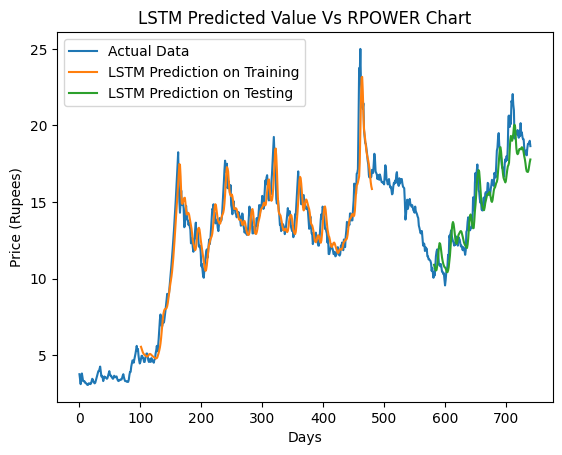

In [49]:
plt.plot(RPOWER1)

df_train = pd.DataFrame(train_predict)
train_index = [i for i in range(101, 101+len(train_predict))]
df_train["index"] = train_index
df_train.set_index("index", inplace=True)
plt.plot(df_train)

df_test = pd.DataFrame(test_predict)
test_index = [i for i in range(582, 582+len(test_predict))]
df_test["index"] = test_index
df_test.set_index("index", inplace=True)
plt.plot(df_test)

plt.title("LSTM Predicted Value Vs RPOWER Chart")
plt.xlabel("Days")
plt.ylabel("Price (Rupees)")
plt.legend(["Actual Data", "LSTM Prediction on Training", "LSTM Prediction on Testing"])

plt.savefig("LSTM_Predict.jpg")